In [2]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import transformer_lens

from probe_model import LinearProbe

/home/rsn3254/.conda/envs/jupyter-kernel-py38/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [7]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [43]:
def load_probe(ckpt_path, dim, num_classes=10):
    model = LinearProbe(device=device, num_input_features=dim, num_classes=num_classes)
    model.load_state_dict(torch.load(f"{ckpt_path}/checkpoint.ckpt", map_location=device))
    model.eval()
    return model

In [9]:
LAYER = 2
folder = f"ckpts/{model_name}/prewar/layer{LAYER}"
probe = load_probe(folder)

## Visualizing probe prediction per word in sample sentence

In [50]:
PREFIX = "Hello and welcome to my blog, where I love to list words.\n"
prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

s_example = '''This is an example test sentence.'''
t_example = model.to_tokens(PREFIX + s_example, prepend_bos=True)

print(s_example)
print(t_example)

_, cache = model.run_with_cache(t_example, names_filter=lambda x: x.endswith("resid_post"))
residuals = cache.stack_activation("resid_post")
residuals = residuals[:, :, prefix_len:, :]
residuals.shape

This is an example test sentence.
tensor([[50256, 15496,   290,  7062,   284,   616,  4130,    11,   810,   314,
          1842,   284,  1351,  2456,    13,   198,  1212,   318,   281,  1672,
          1332,  6827,    13]], device='cuda:0')


torch.Size([24, 1, 8, 1024])

In [51]:
x_example = residuals.squeeze(1)

In [52]:
logits = probe(x_example[LAYER, :, :])

In [53]:
single_dir = logits[:, 1]
single_dir

tensor([ 5.9384, 11.6925, 16.4778, 13.9356, 13.0697, 11.2155,  9.4837, 11.5942],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [54]:
token_idxs = t_example[0][prefix_len:]
token_strs = [model.to_single_str_token(tid.item()) for tid in token_idxs]
token_strs

['\n', 'This', ' is', ' an', ' example', ' test', ' sentence', '.']

In [55]:
val_range = (torch.min(single_dir), torch.max(single_dir))
vals = (single_dir - val_range[0]) / (val_range[1] - val_range[0])
vals = vals.detach().cpu().numpy()

In [56]:

gradient_text = ""
#179, 232, 247 --> 103, 137, 247
# Define RGB values for light blue and dark blue
light_blue_rgb = (230, 230, 247)  # Light blue
dark_blue_rgb = (120, 120, 247)       # Dark blue

max_width = 100000000
current_width = 0
for token, i in zip(token_strs, vals):
    # Add color block behind text
    # Calculate the interpolated RGB color
    interpolated_color_rgb = tuple(int(light_blue_rgb[c] + (i) * (dark_blue_rgb[c] - light_blue_rgb[c])) for c in range(3))
    # Apply the interpolated color to the text
    
    if current_width + 1 > max_width:
            gradient_text += "\n"
            current_width = 0
    current_width += len(token)
    gradient_text += f"\033[48;2;{interpolated_color_rgb[0]};{interpolated_color_rgb[1]};{interpolated_color_rgb[2]}m{token}\033[0m"
print(gradient_text)


This is an example test sentence.


In [57]:
# For Displaying All Directions

for direction in range(1,6):
    x_example = residuals.squeeze(1)
    logits = probe(x_example[LAYER, :, :])
    single_dir = logits[:, direction]
    token_idxs = t_example[0][prefix_len:]
    token_strs = [model.to_single_str_token(tid.item()) for tid in token_idxs]
    val_range = (torch.min(single_dir), torch.max(single_dir))
    vals = (single_dir - val_range[0]) / (val_range[1] - val_range[0])
    vals = vals.detach().cpu().numpy()
    gradient_text = ""
    #179, 232, 247 --> 103, 137, 247
    # Define RGB values for light blue and dark blue
    light_blue_rgb = (230, 230, 247)  # Light blue
    dark_blue_rgb = (120, 120, 247)       # Dark blue

    max_width = 1000
    current_width = 0
    for token, i in zip(token_strs, vals):
        # Add color block behind text
        # Calculate the interpolated RGB color
        interpolated_color_rgb = tuple(int(light_blue_rgb[c] + (i) * (dark_blue_rgb[c] - light_blue_rgb[c])) for c in range(3))
        # Apply the interpolated color to the text

        if current_width + 1 > max_width:
                gradient_text += "\n"
                current_width = 0
        current_width += len(token)
        gradient_text += f"\033[48;2;{interpolated_color_rgb[0]};{interpolated_color_rgb[1]};{interpolated_color_rgb[2]}m{token}\033[0m"
    print(gradient_text)


This is an example test sentence.

This is an example test sentence.

This is an example test sentence.

This is an example test sentence.

This is an example test sentence.


In [49]:
# For Running and Displaying Multiple Checkpoints

model_name = "gpt2-medium"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

LAYER = 2
folders = [("ckpts/gpt2-medium/brown_10qbin_366k/layer2", 10),("ckpts/gpt2-medium/prewar_10qbin_425k/layer2",10)]
#folder = f"ckpts/{model_name}/prewar/layer{LAYER}"'

for folder, num_class in folders:

    probe = load_probe(folder, model.cfg.d_model, num_class)

    PREFIX = "Hello and welcome to my blog, where I love to list words.\n"
    prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

    s_example = '''The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.'''
    t_example = model.to_tokens(PREFIX + s_example, prepend_bos=True)

    _, cache = model.run_with_cache(t_example, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")
    residuals = residuals[:, :, prefix_len:, :]
    residuals.shape

    x_example = residuals.squeeze(1)
    logits = probe(x_example[LAYER, :, :])
    single_dir = logits[:, 1]
    token_idxs = t_example[0][prefix_len:]
    token_strs = [model.to_single_str_token(tid.item()) for tid in token_idxs]
    val_range = (torch.min(single_dir), torch.max(single_dir))
    vals = (single_dir - val_range[0]) / (val_range[1] - val_range[0])
    vals = vals.detach().cpu().numpy()
    gradient_text = ""
    #179, 232, 247 --> 103, 137, 247
    # Define RGB values for light blue and dark blue
    light_blue_rgb = (230, 230, 247)  # Light blue
    dark_blue_rgb = (120, 120, 247)       # Dark blue

    max_width = 110
    current_width = 0
    for token, i in zip(token_strs, vals):
        # Add color block behind text
        # Calculate the interpolated RGB color
        interpolated_color_rgb = tuple(int(light_blue_rgb[c] + (i) * (dark_blue_rgb[c] - light_blue_rgb[c])) for c in range(3))
        # Apply the interpolated color to the text

        if current_width + 1 > max_width:
                gradient_text += "\n"
                current_width = 0
        current_width += len(token)
        gradient_text += f"\033[48;2;{interpolated_color_rgb[0]};{interpolated_color_rgb[1]};{interpolated_color_rgb[2]}m{token}\033[0m"
    print(gradient_text)

Loaded pretrained model gpt2-medium into HookedTransformer

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an
 encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention
 mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms
, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these
 models to be superior in quality while being more parallelizable and requiring significantly less time to train
. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing
 best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model
 establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs,
 a small fraction of the training costs

In [284]:
# def black_to_white_gradient_text(text):
#     gradient_text = ""
#     num_steps = len(text)

#     for i, char in enumerate(text):
#         # Calculate the interpolated grayscale color code
#         interpolated_color_code = int(232 + (23/2) + (i / num_steps) * (23/2))
#         # Apply the interpolated grayscale color to the text
#         gradient_text += f"\033[48;5;{interpolated_color_code}m{char}\033[0m"

#     return gradient_text

# # Example text
# text = "Gradient from black to white kajsdhfkjladshfkjahdskfljhadlskfhlaksdjfhklajsdhflkashdfkljahsdklfhasdklfjhaskldfjhaldskfjhalskdf"

# # Generate the gradient text
# gradient_text = black_to_white_gradient_text(text)

# # Print the gradient text
# print(gradient_text)


In [285]:
# def blue_gradient_text(text):
#     gradient_text = ""
#     num_steps = len(text)
# #179, 232, 247 --> 103, 137, 247
#     # Define RGB values for light blue and dark blue
#     light_blue_rgb = (230, 230, 247)  # Light blue
#     dark_blue_rgb = (120, 120, 247)       # Dark blue

#     for i, char in enumerate(text):
#         # Calculate the interpolated RGB color
#         interpolated_color_rgb = tuple(int(light_blue_rgb[c] + (i / num_steps) * (dark_blue_rgb[c] - light_blue_rgb[c])) for c in range(3))
#         # Apply the interpolated color to the text
#         gradient_text += f"\033[48;2;{interpolated_color_rgb[0]};{interpolated_color_rgb[1]};{interpolated_color_rgb[2]}m{char}\033[0m"

#     return gradient_text

# # Example text
# text = "Gradient from light blue to dark blue"

# # Generate the gradient text
# gradient_text = blue_gradient_text(text)

# # Print the gradient text
# print(gradient_text)


## Cosine similarity within probe

In [ ]:
LAYER = 2
folder = f"ckpts/{model_name}/prewar_baseline/layer{LAYER}"
probe = load_probe(folder, num_classes=20)

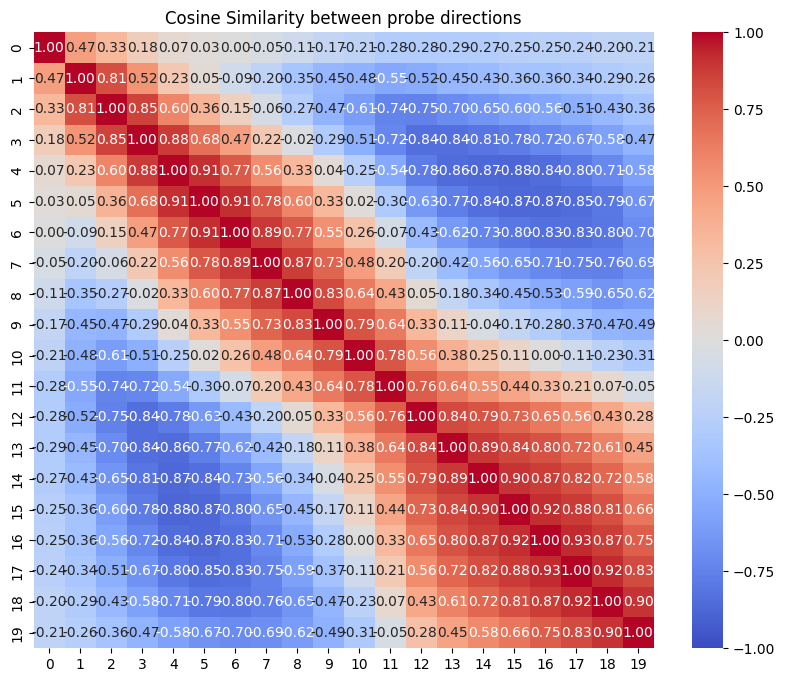

In [33]:
import seaborn as sns


def compute_cosine_similarity(matrix):
    # Normalize the rows to get the direction vectors
    norm_matrix = matrix / matrix.norm(dim=1, keepdim=True)
    # Compute cosine similarity
    similarity = torch.mm(norm_matrix, norm_matrix.t())
    return similarity

def visualize_similarity(similarity_matrix):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    ax.set_title('Cosine Similarity between probe directions')
    plt.show()


weights = probe.linear.weight.data

# Compute the cosine similarity matrix
cosine_similarity = compute_cosine_similarity(weights).cpu().numpy()

# Visualize the cosine similarity matrix
visualize_similarity(cosine_similarity)
